### Google Drive Mount
Code for mounting the google drive on the Colab Notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Fri Apr 16 17:25:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install torch torchvision

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Data Loading & Encoding

In [ ]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import np_utils

# Select option for training RF/NB  OR ANN
classifier_method = 'ANN'

# Uncomment the relevatn Dataset
# file_dir = 'gdrive/My Drive/IIT Bhilai Internship/Models/Symptom ID/'
if(classifier_method=='RF/NB'):
  file_dir = 'gdrive/My Drive/GA Project/Models/SymCat Random Forest Model/'
if(classifier_method=='ANN'):
  file_dir = 'gdrive/My Drive/GA Project/Models/ANN Classifier/'
import os
for dirname, _, filenames in os.walk(file_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

gdrive/My Drive/GA Project/Models/ANN Classifier/Training_NN.csv
gdrive/My Drive/GA Project/Models/ANN Classifier/Testing_NN.csv
gdrive/My Drive/GA Project/Models/ANN Classifier/Testing.csv
gdrive/My Drive/GA Project/Models/ANN Classifier/Training.csv
gdrive/My Drive/GA Project/Models/ANN Classifier/data.csv
gdrive/My Drive/GA Project/Models/ANN Classifier/model.pt


In [ ]:
# In case you want to use the prevalance of a symptom in the disease
#   Uncoment the 'Training_Prob.csv' & 'Testing_Prob' lines & comment the other 

if(classifier_method=='RF/NB'):
  df = pd.read_csv(file_dir + 'Training.csv')
  df_test = pd.read_csv(file_dir + 'Testing.csv')

if(classifier_method=='ANN'):
#   df = pd.read_csv(file_dir + 'Training_NN.csv')
  df = pd.read_csv(file_dir + 'data.csv')
  df = df.sample(frac=1).reset_index(drop=True)


  rows = len(df.index)
  test_ratio =0.1
  train_ratio = 1-test_ratio
  df_train = df.iloc[:int(train_ratio*rows),:]
  df_test = df.iloc[int(train_ratio*rows+1):,:]

#   df_test = pd.read_csv(file_dir + 'Testing_NN.csv')

# df = pd.read_csv(file_dir + 'Training_Prob.csv')
# df_test = pd.read_csv(file_dir + 'Testing_Prob.csv')

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
arn = pd.concat([df_train['prognosis'], df_test['prognosis']])
le.fit(arn)
print(len(le.classes_))

x_train = df_train[df_train.columns.difference(['prognosis'])]
y_train = le.fit_transform(df_train['prognosis'])

x_test = df_test[df_test.columns.difference(['prognosis'])]
y_test = le.fit_transform(df_test['prognosis'])
# y_test = np_utils.to_categorical(y_test)

# print(type(x_train))
# print(type(y_train))
# y_test

48


In [ ]:
df = pd.read_csv(file_dir + 'Training.csv')
rows = len(df.index)
test_ratio =0.1
train_ratio = 1-test_ratio
df_train = df.iloc[:int(train_ratio*rows),:]
df_test = df.iloc[int(train_ratio*rows+1):,:]

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
arn = pd.concat([df_train['prognosis'], df_test['prognosis']])
le.fit(arn)
print(len(le.classes_))

x_train = df_train[df_train.columns.difference(['prognosis'])]
y_train = le.fit_transform(df_train['prognosis'])

x_test = df_test[df_test.columns.difference(['prognosis'])]
y_test = le.fit_transform(df_test['prognosis'])

48


### Neural Network

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

symp_train_data = torch.tensor(x_train.values, dtype=torch.int64).to(device)
train_outputs = torch.tensor(y_train).to(device)

symp_test_data = torch.tensor(x_test.values, dtype=torch.int64).to(device)
test_outputs = torch.tensor(y_test).to(device)

print(symp_train_data.shape)
print(train_outputs.shape)

categorical_column_sizes = [2 for column in df.columns.difference(['prognosis'])]
categorical_embedding_sizes = [(2, min(50, (2+1)//2)) for column in df.columns.difference(['prognosis'])]
# print(symp_train_data.shape[0])

torch.Size([8812, 144])
torch.Size([8812])


In [ ]:
class Model(nn.Module):

    def __init__(self, embedding_size, output_size, layers, p=0.4, weights = None):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        # self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        # self.weight = torch.nn.Parameter(torch.Tensor
        if weights!= None:
            for i in range(len(self.modules())):
                (self.modules())[i].weight = weights[i]

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        # x_numerical = self.batch_norm_num(x_numerical)
        # x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

# model = Model(categorical_embedding_sizes, 48, [200,100,50,25], p=0.4) # 48 = no. of diseases selected.
# device = torch.device("cuda" if use_cuda else "cpu")
# model = MyRNN()


# print(model)

In [ ]:
# import wandb

# # 1. Start a W&B run
# wandb.init(project='hp3', entity='parv')
model = Model(categorical_embedding_sizes, 48, [200], p=0.1).to(device) # 48 = no. of diseases selected.
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 150
aggregated_losses = []

for i in range(epochs):
    y_pred = model(symp_train_data)
    # print(y_pred.is_cuda)
    single_loss = loss_function(y_pred,train_outputs)
    # aggregated_losses.append(single_loss)

    # if i%25 == 1:
    # print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
# Finding Target Variable
with torch.no_grad():
    # y_val = model(symp_train_data)
    y_val = model(symp_test_data)

    # loss = loss_function(y_val, train_outputs)
    loss = loss_function(y_val, test_outputs)

# print(f'Loss: {loss:.8f}')

y_val = np.argmax(y_val.cpu(), axis=1)
# print(y_val[:5])

In [ ]:
# plt.plot(range(epochs), aggregated_losses)
# plt.ylabel('Loss')
# plt.xlabel('epoch');

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print(test_outputs[:5])
# print(y_val[:5])
# print(confusion_matrix(test_outputs,y_val))
# print(classification_report(test_outputs,y_val))
#  print(accuracy_score(train_outputs, y_val))
print(accuracy_score(test_outputs.cpu(), y_val))


0.8426966292134831


# SAVING THE MODEL

In [ ]:
torch.save(model,file_dir +'/model.pt')

# LOADING THE MODEL

In [ ]:
# Model class must be defined somewhere
model = torch.load( file_dir +'/model.pt')
model.eval()

# GA Implementation

In [ ]:
symp_train_data = tf.convert_to_tensor(x_train.values, dtype=tf.int64)
# symp_train_data = tf.constant([1,2,3,4,5])
train_outputs =  tf.convert_to_tensor(y_train)

symp_test_data =  tf.convert_to_tensor(x_test.values, dtype=tf.int64)
test_outputs =  tf.convert_to_tensor(y_test)
# print(symp_train_data.device)
print(symp_train_data.shape)
print(train_outputs.shape)

categorical_column_sizes = [2 for column in df.columns.difference(['prognosis'])]
categorical_embedding_sizes = [(2, min(50, (2+1)//2)) for column in df.columns.difference(['prognosis'])]
# print(symp_train_data.shape[0])

(8769, 144)
(8769,)


In [ ]:
import random
import logging
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import keras

In [ ]:
!pip install pygad

     |████████████████████████████████| 51kB 4.5MB/s 


In [ ]:
import numpy
import pygad.nn

# Reading the data features. Check the 'extract_features.py' script for extracting the features & preparing the outputs of the dataset.
data_inputs = x_train.to_numpy() # Download from https://github.com/ahmedfgad/NumPyANN/blob/master/dataset_features.npy

# # Optional step for filtering the features using the standard deviation.
# features_STDs = numpy.std(a=data_inputs, axis=0)
# data_inputs = data_inputs[:, features_STDs > 50]

# Reading the data outputs. Check the 'extract_features.py' script for extracting the features & preparing the outputs of the dataset.
data_outputs = y_train # Download from https://github.com/ahmedfgad/NumPyANN/blob/master/outputs.npy

# The number of inputs (i.e. feature vector length) per sample
num_inputs = data_inputs.shape[1]
# Number of outputs per sample
num_outputs = 48

HL1_neurons = 250
# HL2_neurons = 60

# Building the network architecture.
input_layer = pygad.nn.InputLayer(num_inputs)
hidden_layer1 = pygad.nn.DenseLayer(num_neurons=HL1_neurons, previous_layer=input_layer, activation_function="relu")
# hidden_layer2 = pygad.nn.DenseLayer(num_neurons=HL2_neurons, previous_layer=hidden_layer1, activation_function="relu")
output_layer = pygad.nn.DenseLayer(num_neurons=num_outputs, previous_layer=hidden_layer1, activation_function="softmax")

# Training the network.
pygad.nn.train(num_epochs=10,
               last_layer=output_layer,
               data_inputs=data_inputs,
               data_outputs=data_outputs,
               learning_rate=0.01)

# Using the trained network for predictions.
predictions = pygad.nn.predict(last_layer=output_layer, data_inputs=data_inputs)

# Calculating some statistics
# num_wrong = numpy.where(predictions != data_outputs)[0]
# num_correct = data_outputs.size - num_wrong.size
# accuracy = 100 * (num_correct/data_outputs.size)
# predict_label =  pygad.nn.predict
predict_label = np.argmax(predictions, axis=-1)
ann.fitness = accuracy_score(train_outputs.cpu(), predict_label)
print("Number of correct classifications : {num_correct}.".format(num_correct=num_correct))
print("Number of wrong classifications : {num_wrong}.".format(num_wrong=num_wrong.size))
print("Classification accuracy : {accuracy}.".format(accuracy=accuracy))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Instructions for updating:
Use tf.identity instead.


TypeError: ignored

(8812, 144)
Generation = 1
Fitness    = 2.076713572401271
Change     = 2.076713572401271
Generation = 2
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 3
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 4
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 5
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 6
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 7
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 8
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 9
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 10
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 11
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 12
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 13
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 14
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 15
Fitness    = 2.076713572401271
Change     = 0.0
Generation = 16
Fitness

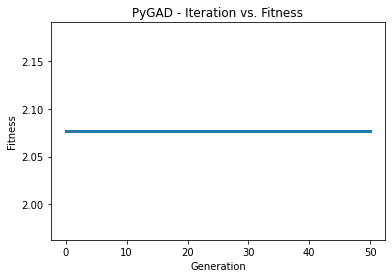

Parameters of the best solution : [ 2.57085498 -0.01972712 -0.5189307  ... -4.81016531 -0.52108124
  0.73242979]
Fitness value of the best solution = 2.076713572401271
Index of the best solution : 0
Best fitness value reached after 0 generations.
Predictions of the trained network : [14, 43, 43, 10, 37, 41, 4, 40, 16, 36, 22, 32, 43, 12, 0, 24, 36, 36, 42, 36, 43, 37, 14, 43, 0, 37, 47, 15, 40, 43, 41, 0, 14, 0, 4, 17, 18, 36, 47, 15, 7, 14, 22, 14, 38, 40, 43, 43, 13, 14, 30, 9, 43, 41, 36, 38, 43, 0, 18, 37, 0, 36, 24, 13, 40, 36, 13, 16, 40, 36, 43, 36, 14, 0, 0, 38, 36, 43, 4, 13, 36, 12, 24, 30, 43, 36, 31, 40, 11, 16, 15, 13, 0, 15, 43, 36, 0, 10, 43, 37, 29, 0, 36, 36, 12, 18, 43, 40, 25, 43, 40, 43, 30, 37, 13, 43, 0, 36, 15, 3, 36, 2, 36, 18, 42, 6, 37, 6, 0, 14, 33, 38, 36, 24, 47, 45, 0, 43, 40, 36, 15, 6, 24, 43, 14, 13, 36, 43, 0, 13, 42, 0, 43, 14, 37, 6, 40, 4, 5, 36, 21, 36, 24, 41, 16, 37, 24, 36, 41, 14, 43, 40, 15, 12, 36, 16, 38, 24, 18, 35, 36, 47, 43, 6, 12, 14, 1

In [ ]:
import numpy
import pygad
import pygad.nn
import pygad.gann

def fitness_func(solution, sol_idx):
    global GANN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs)
    predictions = np.array(predictions).reshape(data_inputs.shape[0] , 1)
    # print(predictions.shape)

    # print(predictions[0])
    # print(data_outputs[0])
    predict_label = np.argmax(predictions, axis=-1)
    # print(predict_label.shape)

    solution_fitness = accuracy_score(data_outputs, predict_label)*100
    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks,
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))

    last_fitness = ga_instance.best_solution()[1].copy()

# Holds the fitness value of the previous generation.
last_fitness = 0

# Reading the input data.
data_inputs = x_train.to_numpy() # Download from https://github.com/ahmedfgad/NumPyANN/blob/master/dataset_features.npy

# Reading the output data.
data_outputs = y_train # Download from https://github.com/ahmedfgad/NumPyANN/blob/master/outputs.npy

# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = data_inputs.shape[1]
# The number of neurons in the output layer (i.e. number of classes).
num_classes = 48

# Creating an initial population of neural networks. The return of the initial_population() function holds references to the networks, not their weights. Using such references, the weights of all networks can be fetched.
num_solutions = 20 # A solution or a network can be used interchangeably.
GANN_instance = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=num_inputs,
                                num_neurons_hidden_layers=[200],
                                num_neurons_output=num_classes,
                                hidden_activations=["relu"],
                                output_activation="softmax")

# population does not hold the numerical weights of the network instead it holds a list of references to each last layer of each network (i.e. solution) in the population. A solution or a network can be used interchangeably.
# If there is a population with 3 solutions (i.e. networks), then the population is a list with 3 elements. Each element is a reference to the last layer of each network. Using such a reference, all details of the network can be accessed.
population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
initial_population = population_vectors.copy()

num_parents_mating = 8 # Number of solutions to be selected as parents in the mating pool.

num_generations = 50 # Number of generations.

mutation_percent_genes = 10 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

parent_selection_type = "sss" # Type of parent selection.

crossover_type = "scattered" # Type of the crossover operator.

mutation_type = "random" # Type of the mutation operator.

keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       crossover_probability = 0.9,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Predicting the outputs of the data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                               data_inputs=data_inputs)
print("Predictions of the trained network : {predictions}".format(predictions=predictions))

# Calculating some statistics
# num_wrong = numpy.where(predictions != data_outputs)[0]
# num_correct = data_outputs.size - num_wrong.size
# accuracy = 100 * (num_correct/data_outputs.size)
# print("Number of correct classifications : {num_correct}.".format(num_correct=num_correct))
# print("Number of wrong classifications : {num_wrong}.".format(num_wrong=num_wrong.size))
# print("Classification accuracy : {accuracy}.".format(accuracy=accuracy))

In [ ]:
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(message)s',
                    handlers=[logging.FileHandler("ann_test.log"),
                              logging.StreamHandler()])

p_cross = 0.5
p_mut = 0.3
num_parents = 10
# num_of_crossovers_per_parent = 3
population = 30
epochs = 50
epochs_per_nn = 1

class ANN(Sequential):
    
    def __init__(self, child_weights=None):
        super().__init__()

        self.fitness = 0
        if child_weights is None:
            layer1 = Dense(200, input_shape=(144,), activation='relu')
            layer2 = Dense(48, activation=None)
            self.add(layer1)
            self.add(layer2)

    def forward_propagation(self, train_feature, train_label):
        predict_label = self.predict(train_feature)

def crossover(nn1, nn2):
    global p_cross , symp_train_data  , train_outputs
    nn1_weights = []
    nn2_weights = []
    child_weights = []

    for layer in nn1.layers:
        nn1_weights.append(layer.get_weights()[0])
    # print(len(nn1_weights[1]))
    for layer in nn2.layers:
        nn2_weights.append(layer.get_weights()[0])

    for i in range(len(nn1_weights)):
        # Get single point to split the matrix in parents based on # of cols
        # split = random.randint(0, np.shape(nn1_weights[i])[1]-1)
        # # Iterate through after a single point and set the remaing cols to nn_2
        # for j in range(split, np.shape(nn1_weights[i])[1]-1):
        #     nn1_weights[i][:, j] = nn2_weights[i][:, j]
        for j in range(len(np.shape(nn1_weights[i]))):
            cross = random.random()         #uniform crossover
            if cross<p_cross:
                nn1_weights[i][j] = nn2_weights[i][j];
       
        child_weights.append(nn1_weights[i])

    mutation(child_weights)
    final_child_weights=nn1.get_weights()

    final_child_weights[0] = child_weights[0]
    final_child_weights[2] = child_weights[1]
    
    child = ANN()
    child.set_weights(final_child_weights)
    
    predict_label =  child.predict(symp_train_data)
    preds_classes = np.argmax(predict_label, axis=-1)
    child.fitness = accuracy_score(train_outputs, preds_classes)
    print("Fitness of the child is ",str(child.fitness))
    return child

def mutation(child_weights):
    global p_mut
    for i in range(len(child_weights)):
    # selection = random.randint(0, len(child_weights)-1)
        mut = random.random()
        if mut <= p_mut:
            child_weights[i] *= random.uniform(0.7,1.3)
        else:
            pass

# # train feature
# train_feature = x_train.to_numpy()
# # train label
# train_label = y_train
# # test feature
# test_feature = x_test.to_numpy()
# # test label
# test_label = y_test

# store all active ANNs
networks = []
pool = []
# Generation counter
generation = 0
# Initial Population

for i in range(population):
    pool.append(ANN())
# Track Max Fitness
max_fitness = 0
# Store Max Fitness Weights
optimal_weights = []
next_gen_confirmed = []
fitness_per_generation = []
best_model = ANN()
# Evolution Loop
for i in range(epochs):
    generation += 1
    logging.debug("Generation: " + str(generation) + "\r\n")
    z=0
    # print(len(networks))
    networks = []
    for ann in pool:
        # print(z)
        # z+=1
        # Propagate to calculate fitness score
        ann.compile(optimizer=optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
                    metrics=[keras.metrics.SparseCategoricalAccuracy()])
        ann.fit(x=symp_train_data, y = train_outputs , epochs = epochs_per_nn, verbose=0)
        predict_label =  ann.predict(symp_train_data,)
        preds_classes = np.argmax(predict_label, axis=-1)
        ann.fitness = accuracy_score(train_outputs, preds_classes)
        # Add to pool after calculating fitness
        networks.append(ann)

    # # Clear for propagation of next children
    # # networks.clear()
    pool = networks
    # Sort anns by fitness
    pool+= next_gen_confirmed
    pool = sorted(pool, key=lambda x: x.fitness)
    pool.reverse()

    pool = pool[:population]

    next_gen_confirmed = pool[:3]
    # Find Max Fitness and Log Associated Weights
    # for i in range(len(pool)):
    fitness_per_generation.append(pool[0].fitness)

    logging.debug("Max Fitness of generation : " + str(pool[0].fitness) + "\r\n")
    # logging.debug("Max Fitness of generation from back  : " + str(pool[len(pool)-1].fitness) + "\r\n")
    if pool[0].fitness > max_fitness:
        max_fitness = pool[0].fitness

        logging.debug("Max Fitness: " + str(max_fitness) + "\r\n")

        # Iterate through layers, get weights, and append to optimal
        # optimal_weights = []
        # for layer in pool[0].layers:
        #     optimal_weights.append(layer.get_weights()[0])
        # logging.debug('optimal_weights: ' + str(optimal_weights)+"\r\n")

        best_model = pool[0]
    child = []
    # Crossover: top 5 randomly select 2 partners
    for i in range(num_parents):
        # for j in range(num_of_crossovers_per_parent):
            # Create a child and add to networks
        target = (i+1) % num_parents
        temp = crossover(pool[i],pool[target])
        child.append(temp.get_weights())
        # Add to networks to calculate fitness score next iteration
        pool.append(temp)
    # for i in range(num_parents-1):
    #     comparison = np.array_equal(child[i],child[i+1])
    #     # equal_arrays = comparison.all()
    #     print(comparison)

# Create a Genetic Neural Network with optimal initial weights

2021-04-16 17:29:31,816 Generation: 1

2021-04-16 17:29:56,920 Max Fitness of generation : 0.883795187592656

2021-04-16 17:29:56,921 Max Fitness: 0.883795187592656



Fitness of the child is  0.883795187592656
Fitness of the child is  0.8836811495039343
Fitness of the child is  0.8836811495039343
Fitness of the child is  0.883453073326491
Fitness of the child is  0.8825407686167179
Fitness of the child is  0.8829969209716045
Fitness of the child is  0.8829969209716045
Fitness of the child is  0.8829969209716045
Fitness of the child is  0.8817425019956665


2021-04-16 17:30:00,601 Generation: 2



Fitness of the child is  0.8835671114152127


2021-04-16 17:30:34,426 Max Fitness of generation : 0.885961911278367

2021-04-16 17:30:34,427 Max Fitness: 0.885961911278367



Fitness of the child is  0.8852776827460371
Fitness of the child is  0.8850496065685939
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8847074923024291
Fitness of the child is  0.8856197970122021
Fitness of the child is  0.8847074923024291
Fitness of the child is  0.8849355684798723
Fitness of the child is  0.8843653780362641
Fitness of the child is  0.8845934542137074


2021-04-16 17:30:36,829 Generation: 3



Fitness of the child is  0.8849355684798723


2021-04-16 17:31:11,632 Max Fitness of generation : 0.8857338351009237



Fitness of the child is  0.8855057589234805
Fitness of the child is  0.8850496065685939
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8851636446573156
Fitness of the child is  0.8851636446573156
Fitness of the child is  0.8845934542137074
Fitness of the child is  0.8855057589234805
Fitness of the child is  0.8850496065685939


2021-04-16 17:31:14,099 Generation: 4



Fitness of the child is  0.8844794161249857


2021-04-16 17:31:49,247 Max Fitness of generation : 0.8860759493670886

2021-04-16 17:31:49,248 Max Fitness: 0.8860759493670886



Fitness of the child is  0.885961911278367
Fitness of the child is  0.8849355684798723
Fitness of the child is  0.8848215303911506
Fitness of the child is  0.8856197970122021
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8852776827460371
Fitness of the child is  0.8855057589234805


2021-04-16 17:31:51,837 Generation: 5



Fitness of the child is  0.8855057589234805


2021-04-16 17:32:27,790 Max Fitness of generation : 0.8860759493670886



Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8842513399475425
Fitness of the child is  0.8856197970122021
Fitness of the child is  0.8849355684798723
Fitness of the child is  0.8844794161249857
Fitness of the child is  0.8855057589234805
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8844794161249857


2021-04-16 17:32:30,362 Generation: 6



Fitness of the child is  0.8849355684798723


2021-04-16 17:33:06,446 Max Fitness of generation : 0.8860759493670886



Fitness of the child is  0.885961911278367
Fitness of the child is  0.8845934542137074
Fitness of the child is  0.8844794161249857
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.885961911278367
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8860759493670886


2021-04-16 17:33:09,097 Generation: 7



Fitness of the child is  0.8856197970122021


2021-04-16 17:33:45,291 Max Fitness of generation : 0.8860759493670886



Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8839092256813775
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8858478731896453


2021-04-16 17:33:47,711 Generation: 8



Fitness of the child is  0.8849355684798723


2021-04-16 17:34:23,987 Max Fitness of generation : 0.8861899874558102

2021-04-16 17:34:23,989 Max Fitness: 0.8861899874558102



Fitness of the child is  0.885961911278367
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8856197970122021
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8857338351009237


2021-04-16 17:34:26,440 Generation: 9



Fitness of the child is  0.8853917208347588


2021-04-16 17:35:01,358 Max Fitness of generation : 0.8863040255445319

2021-04-16 17:35:01,360 Max Fitness: 0.8863040255445319



Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8855057589234805
Fitness of the child is  0.8851636446573156
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8852776827460371
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8857338351009237


2021-04-16 17:35:03,937 Generation: 10



Fitness of the child is  0.8849355684798723


2021-04-16 17:35:40,188 Max Fitness of generation : 0.8865321017219752

2021-04-16 17:35:40,190 Max Fitness: 0.8865321017219752



Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.885961911278367
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8848215303911506


2021-04-16 17:35:42,739 Generation: 11



Fitness of the child is  0.8857338351009237


2021-04-16 17:36:19,295 Max Fitness of generation : 0.8863040255445319



Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8853917208347588
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8847074923024291
Fitness of the child is  0.8855057589234805
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8858478731896453


2021-04-16 17:36:22,017 Generation: 12



Fitness of the child is  0.8853917208347588


2021-04-16 17:36:58,907 Max Fitness of generation : 0.8864180636332535



Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.8860759493670886


2021-04-16 17:37:01,514 Generation: 13



Fitness of the child is  0.8861899874558102


2021-04-16 17:37:38,021 Max Fitness of generation : 0.8864180636332535



Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8852776827460371
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8858478731896453
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8855057589234805


2021-04-16 17:37:40,666 Generation: 14



Fitness of the child is  0.8850496065685939


2021-04-16 17:38:17,456 Max Fitness of generation : 0.8866461398106967

2021-04-16 17:38:17,457 Max Fitness: 0.8866461398106967



Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8856197970122021
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8860759493670886


2021-04-16 17:38:20,000 Generation: 15



Fitness of the child is  0.885961911278367


2021-04-16 17:38:55,597 Max Fitness of generation : 0.8865321017219752



Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8861899874558102


2021-04-16 17:38:59,129 Generation: 16



Fitness of the child is  0.8861899874558102


2021-04-16 17:39:34,998 Max Fitness of generation : 0.8863040255445319



Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8857338351009237
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.885961911278367
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8860759493670886


2021-04-16 17:39:38,605 Generation: 17



Fitness of the child is  0.885961911278367


2021-04-16 17:40:15,071 Max Fitness of generation : 0.8866461398106967



Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8856197970122021


2021-04-16 17:40:17,750 Generation: 18



Fitness of the child is  0.8861899874558102


2021-04-16 17:40:53,388 Max Fitness of generation : 0.8865321017219752



Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8856197970122021


2021-04-16 17:40:57,024 Generation: 19



Fitness of the child is  0.8850496065685939


2021-04-16 17:41:32,581 Max Fitness of generation : 0.8867601778994184

2021-04-16 17:41:32,583 Max Fitness: 0.8867601778994184



Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8851636446573156
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8864180636332535


2021-04-16 17:41:34,994 Generation: 20



Fitness of the child is  0.8865321017219752


2021-04-16 17:42:12,765 Max Fitness of generation : 0.8866461398106967



Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8865321017219752


2021-04-16 17:42:15,388 Generation: 21



Fitness of the child is  0.885961911278367


2021-04-16 17:42:50,475 Max Fitness of generation : 0.8866461398106967



Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8863040255445319
Fitness of the child is  0.8860759493670886
Fitness of the child is  0.8865321017219752
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8861899874558102
Fitness of the child is  0.8864180636332535
Fitness of the child is  0.8861899874558102


2021-04-16 17:42:53,876 Generation: 22



Fitness of the child is  0.8860759493670886


2021-04-16 17:43:29,230 Max Fitness of generation : 0.8867601778994184



Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8867601778994184
Fitness of the child is  0.8867601778994184
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8866461398106967
Fitness of the child is  0.8866461398106967


2021-04-16 17:43:31,632 Generation: 23



Fitness of the child is  0.8866461398106967


KeyboardInterrupt: ignored

In [ ]:
ann = ANN
ann.set_weights(best_model.get_weights())
predict_label =  ann.predict(symp_train_data)
preds_classes = np.argmax(predict_label, axis=-1)
ann.fitness = accuracy_score(train_outputs, preds_classes)

print(ann.fitness)

(144, 200)
0.0206536541080345


### Block for finding the Random Forest Models

The following block need not be run again since optimal hyperparameters have been founded already.

A random forest regressor has been used for the training & testing of the optimal parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [800, 900, 1000, 1500]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

grid_search.fit(x_train, y_train)
grid_search.best_params_

### Model Training (Random Forest/ Naive Bayes)

This is the Training Part of the Model using a random forest classifier. Option is available for Naive Bayes classification also.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# For model
# model = GaussianNB()
model = RandomForestClassifier(n_estimators=1200, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True)

model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
# y_true = le.fit_transform(df_train['prognosis'])
y_pred=model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.0


ValueError: ignored

In [ ]:
le.inverse_transform(model.classes_)

In [ ]:
import pygad
import pygad.nn
import pygad.gann

def fitness_func(solution, sol_idx):
    global GANN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs)
    # correct_predictions = np.where(predictions == data_outputs)[0].size
    # solution_fitness = (correct_predictions/data_outputs.size)*100
    # predict_label =  ann(symp_train_data).detach().cpu().numpy()
    predict_label = np.argmax(predictions, axis=-1)
    solution_fitness = accuracy_score(data_outputs, predict_label)
    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks, 
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Accuracy   = {fitness}".format(fitness=ga_instance.best_solution()[1]))

data_inputs = x_train.to_numpy()

data_outputs = y_train

GANN_instance = pygad.gann.GANN(num_solutions=5,
                                num_neurons_input=144,
                                num_neurons_hidden_layers=[200],
                                num_neurons_output=48,
                                hidden_activations=["relu"],
                                output_activation="softmax")

population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

ga_instance = pygad.GA(num_generations=50, 
                       num_parents_mating=3, 
                       initial_population=population_vectors.copy(),
                       fitness_func=fitness_func,
                       mutation_percent_genes=5,
                       callback_generation=callback_generation)

ga_instance.run()

ga_instance.plot_result()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution)
print(solution_fitness)
print(solution_idx)

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:617: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


Generation = 1
Accuracy   = 2.9505220154334997
Generation = 2
Accuracy   = 2.9505220154334997
Generation = 3
Accuracy   = 2.9505220154334997
Generation = 4


KeyboardInterrupt: ignored

### ANN Training

Training part for an ANN classifier.

### Loading Model

Using pickle to load the saved model.

In [ ]:
import pickle # For loading the saved model
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing # For Label Encoding

file_dir = 'gdrive/My Drive/IIT Bhilai Internship/Models/SymCat Random Forest Model/'

# Loading Features & Label Names
df = pd.read_csv(file_dir + 'Training.csv')
df_test = pd.read_csv(file_dir + 'Testing.csv')

# Label Encodings
le = preprocessing.LabelEncoder()
arn = pd.concat([df['prognosis'], df_test['prognosis']])
le.fit(pd.concat([df['prognosis'], df_test['prognosis']]))

# Loading Model (Naive-Bayes)
model= pickle.load(open(file_dir + 'NB_model_pickle.pkl', 'rb'))

#Loading Model (Random Forest)
# model= pickle.load(open(file_dir + 'NB_model_pickle.pkl', 'rb'))

### Model Test Script

The model is 

In [ ]:
import pickle

with open((file_dir + 'RF_model_pickle.pkl'), 'wb') as f:
  pickle.dump(model,f)